# Solución de la ecuación de Helmholtz usando PINNs

## Descripción del problema

Queremos resolver la siguiente ecuación:

\begin{align}
\Delta u  + k^{2}u = f(x, y)\quad \forall (x, y) \in \Omega\\
u(x, y) = 0\quad \forall (x, y) \in \partial \Omega
\end{align}

En el ejemplo tendremos $\Omega = (0, 1)^2$ y un termino fuente: 

$$
f(x,y) =  -a^2 \sin(a x)\sin(k y)
$$

donde  $a=2$ y $k=2$. La solución exacta es:

$$
u(x, y) =  \sin(a x)\sin(k y)
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
import torch.nn as nn
import time
from pyDOE import lhs
from functools import partial  # Higher-order functions and operations on callable objects
from pinns import *
from plotting import *
import warnings
# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")

In [3]:
def f(model, x_f, y_f, a, k):
    domain = torch.cat([x_f, y_f], dim = 1)
    u = model(domain) 
    u_xx = derivative(u, x_f, order=2)
    u_yy = derivative(u, y_f, order=2)
    f_u = u_xx + u_yy + k**2 * u + a**2 * torch.sin(a * x_f) * torch.sin(k * y_f)
    return f_u

In [4]:
def mse_f(model, x_f, y_f, a, k):
    f_u = f(model, x_f, y_f, a, k)
    return (f_u**2).mean()

In [5]:
def mse_b(model, x_b, y_b):
    # Left boundary
    x_b_left = torch.zeros_like(y_b)
    x_b_left.requires_grad = True
    domain_left = torch.cat([x_b_left, y_b], dim = 1)
    u_b_left = model(domain_left)  

    # Right boundary
    x_b_right = torch.zeros_like(y_b) + torch.pi
    x_b_right.requires_grad = True
    domain_right = torch.cat([x_b_right, y_b], dim = 1)
    u_b_right = model(domain_right)
    
    # Bottom boundary
    y_b_bottom = torch.zeros_like(x_b)
    y_b_bottom.requires_grad = True
    domain_right = torch.cat([x_b,y_b_bottom], dim = 1)
    u_b_bottom = model(domain_right)

    # Top boundary
    y_b_top = torch.zeros_like(x_b) + torch.pi
    y_b_top.requires_grad = True
    domain_top = torch.cat([x_b, y_b_top], dim = 1)
    u_b_top = model(domain_top)

    # Compute MSE for Dirichlet and Neumann boundary conditions
    mse_drichlet = ((u_b_top)**2+(u_b_bottom)**2 + (u_b_left)**2 + (u_b_right)**2).mean()
        
    return mse_drichlet

In [6]:
def closure(model, optimizer, x_f, y_f, x_b, y_b, a, k):
    optimizer.zero_grad()
    loss = mse_f(model, x_f, y_f, a, k) + mse_b(model, x_b, y_b)
    loss.backward(retain_graph=True)
    global iter
    iter += 1
    if iter % 100 == 0:
        print(f"LBFGS - Loss: {loss.item()}")
    return loss

In [7]:
def train_adam(model, x_f, y_f, x_b, y_b, a, k, num_iter=1_000):

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    global iter
     
    for i in range(1, num_iter + 1):
        optimizer.zero_grad()
        loss = mse_f(model, x_f, y_f, a, k) + mse_b(model, x_b, y_b)
        loss.backward(retain_graph=True)
        optimizer.step()
        iter += 1
        if iter % 100 == 0:
            print(f"Adam - Loss: {loss.item()}")

In [8]:
# Function for L-BFGS training
def train_lbfgs(model,x_f, y_f, x_b, y_b, a, k, num_iter=1_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
 
    closure_fn = partial(closure, model, optimizer, x_f, y_f, x_b, y_b, a, k)
    optimizer.step(closure_fn)

In [ ]:
device = torch.device('cpu')

# Initialize iteration counter
iter = 0  
# define the parameters
a = 2
k = 2

# Define lower and upper bounds for the domain
lb = np.array([0.0, 0.0])
ub = np.array([np.pi, np.pi])  
N_b = 100  
N_f = 10_000 
c_f = lb + (ub-lb)*lhs(2, N_f)
x_f = torch.from_numpy(c_f[:, 0]).float().reshape(-1,1).to(device)
x_f.requires_grad = True
y_f = torch.from_numpy(c_f[:, 1]).float().reshape(-1,1).to(device)
y_f.requires_grad = True

c_b = lb + (ub-lb)*lhs(2, N_b)
x_b = torch.from_numpy(c_b[:, 0]).float().reshape(-1,1).to(device)
x_b.requires_grad = True
y_b = torch.from_numpy(c_b[:, 1]).float().reshape(-1,1).to(device)
y_b.requires_grad = True

# Initialize the model with specified parameters and apply weights
model = MLP(input_size=2, output_size=1, hidden_layers=5, hidden_units=100, activation_function=nn.Tanh()).to(device)
model.apply(init_weights)

train_adam(model, x_f, y_f, x_b, y_b, a, k, num_iter=0)
train_lbfgs(model, x_f, y_f, x_b, y_b, a, k, num_iter=5_000)


LBFGS - Loss: 1.386260986328125
LBFGS - Loss: 0.09534545242786407


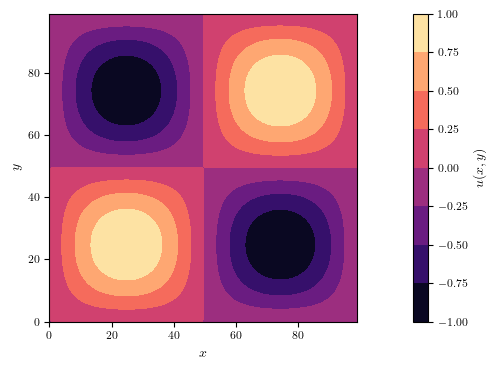

In [9]:
# Número de onda
a = 2
k = 2

# Número de muestras en x y y
dom_samples = 100
x = np.linspace(0, np.pi, dom_samples)
y = np.linspace(0, np.pi, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

def u_exact(x, y, k):
    return np.sin(a*x)*np.sin(k*y)

# Mostrar la solución exacta u(x, y)
plt.figure(figsize=(6, 4))  
img = plt.contourf(u_exact(X, Y, k), cmap='magma')
plt.colorbar(img, label='$u(x,y)$')   
plt.xlabel(r'$x$')   
plt.ylabel(r'$y$')
plt.axis("image")
plt.grid(False)

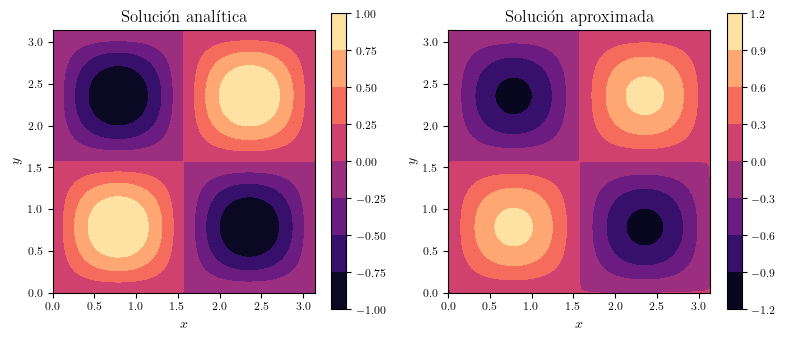

In [10]:
# Convertir los datos X e Y a tensores de PyTorch y cambiar su forma
X_ten = torch.tensor(X).float().reshape(-1, 1).to(device)
Y_ten = torch.tensor(Y).float().reshape(-1, 1).to(device)

# Concatenar los tensores X e Y en un solo tensor
domain_ten = torch.cat([X_ten,Y_ten], dim = 1) 

# Generar predicciones usando la red neuronal y cambiar la forma para que coincida con la cuadrícula
U_pred = model(domain_ten).detach().cpu().numpy().reshape(X.shape)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, u_exact(X, Y,k), cmap='magma')
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Solución analítica")
plt.axis("image")
plt.grid(False)

plt.subplot(1, 2, 2)
plt.contourf(X, Y, U_pred, cmap='magma')
plt.colorbar(shrink=0.8)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("Solución aproximada")
plt.axis("image")
plt.grid(False)

plt.tight_layout()